## Tutorial: Moving vortex in inviscid flow

We investigate the non-reflecting behaviour of various outflow boundary conditions for the motion of a vortex with radius $R$ and strength $\alpha$ in an inviscid flow. The vortex is superimposed on a subsonic ($\operatorname{Ma}_\infty < 1$) baseflow $\bm{u}_\infty$ and is given by
```math
    \begin{align*}
    \psi &= \frac{\alpha R}{\operatorname{Ma}_\infty}  e^{\frac{1 - (r/R)^2}{2}}, &
    \bm{u} &= \bm{u}_\infty + \operatorname{curl}(\psi), \\
    \rho &= \rho_\infty \left(1 - \frac{\gamma- 1}{2} \alpha^2 e^{1 - (r/R)^2}\right)^{\frac{1}{\gamma - 1}}, &
    p &= p_\infty \left(1 - \frac{\gamma- 1}{2} \alpha^2 e^{1 - (r/R)^2}\right)^{\frac{\gamma}{\gamma - 1}}.
    \end{align*}
```

In [10]:
import ngsolve as ngs
from netgen import occ
from ngsolve.webgui import Draw

# Import necessary modules
from dream.compressible import CompressibleFlowSolver, Initial, flowfields, FarField, Outflow, GRCBC
from dream.io import DomainL2Sensor

ngs.ngsglobals.msg_level = 0
ngs.SetNumThreads(4)

In [11]:
# Create mesh
face = occ.WorkPlane().RectangleC(1, 1).Face()
for bc, edge in zip(['bottom', 'right', 'top', 'left'], face.edges):
    edge.name = bc
face.name = "air"
mesh = ngs.Mesh(occ.OCCGeometry(face, dim=2).GenerateMesh(maxh=0.15))

Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [12]:
# Set configuration
cfg = CompressibleFlowSolver(mesh)
cfg.time = "transient"
cfg.time.timer.step = 0.01
cfg.time.timer.interval = (0, 1)

cfg.fem = "conservative"
cfg.fem.order = 4
cfg.fem.method = "hdg"
cfg.fem.mixed_method = "inactive"
cfg.fem.scheme = "bdf2"

cfg.mach_number = 0.3  # TODO: Use various value for the mach number
cfg.equation_of_state = "ideal"
cfg.equation_of_state.heat_capacity_ratio = 1.4
cfg.riemann_solver = 'upwind'
cfg.dynamic_viscosity = "inviscid"
cfg.scaling = "aerodynamic"

# cfg.nonlinear_solver = "pardiso"
cfg.nonlinear_solver.method = "newton"
cfg.nonlinear_solver.convergence_criterion = 1e-8

cfg.optimizations.static_condensation = True

cfg.io.log.to_terminal = True
cfg.io.sensor.enable = True

In [13]:
# Setup boundary and initial fields
Uinf = cfg.get_farfield_fields((1, 0))

R = 0.1  # Vortex radius
ALPHA = 0.03  # Vortex strength


def get_exact_solution_fields(x, y) -> flowfields:
    r = ngs.sqrt(x**2 + y**2)
    G = cfg.equation_of_state.heat_capacity_ratio
    PSI = ALPHA/cfg.mach_number * R * ngs.exp((1 - (r/R)**2)/2)

    U = flowfields()
    U.u = Uinf.u + ngs.CF((PSI.Diff(ngs.y), -PSI.Diff(ngs.x)))
    U.p = Uinf.p * (1 - (G - 1)/2 * ALPHA**2 * ngs.exp(1 - (r/R)**2))**(G/(G - 1))
    U.rho = Uinf.rho * (1 - (G - 1)/2 * ALPHA**2 * ngs.exp(1 - (r/R)**2))**(1/(G - 1))

    return U


t = cfg.time.timer.t
Ue = get_exact_solution_fields(ngs.x - Uinf.u[0] * t, ngs.y - Uinf.u[1] * t)
cfg.dcs['air'] = Initial(Ue)

# Draw perturbation velocity
Draw(Ue.u - Uinf.u, mesh, "u")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [14]:
# Define a decorator for the moving vortex routine
def moving_vortex_routine(func):

    def wrapper(*args, **kwargs):

        cfg.time.timer.reset()
        cfg.io.sensor.list.clear()

        # Set logging paths
        cfg.io.path = func.__name__

        # Clear previous boundary conditions and set new ones
        cfg.bcs.clear()
        cfg.bcs['top|bottom|left'] = FarField(Uinf)
        func(*args, **kwargs)

        # Initialize and solve the configuration
        cfg.initialize()

        # Plot pressure fluctuations
        Uh = cfg.get_solution_fields()
        cfg.io.draw({"p'": (Uh.p - Uinf.p)/Uinf.p}, min=-2e-5, max=2e-5)

        l2_fields = flowfields()
        l2_fields.rho = Ue.rho - Uh.rho
        l2_fields.p = Ue.p - Uh.p
        l2_fields.u = Ue.u - Uh.u

        l2 = DomainL2Sensor(l2_fields, mesh, "air", "l2")
        cfg.io.sensor.add(l2)

        with ngs.TaskManager():
            cfg.solve()

    return wrapper

In [15]:
@moving_vortex_routine
def farfield():
    cfg.bcs['right'] = FarField(Uinf)
farfield()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [16]:
@moving_vortex_routine
def outflow():
    cfg.bcs['right'] = Outflow(pressure=Uinf.p)
outflow()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [17]:
@moving_vortex_routine
def grcbc():
    cfg.bcs['right'] = GRCBC(Uinf, "outflow", relaxation_factor=0.01, tangential_relaxation=cfg.mach_number)
grcbc()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

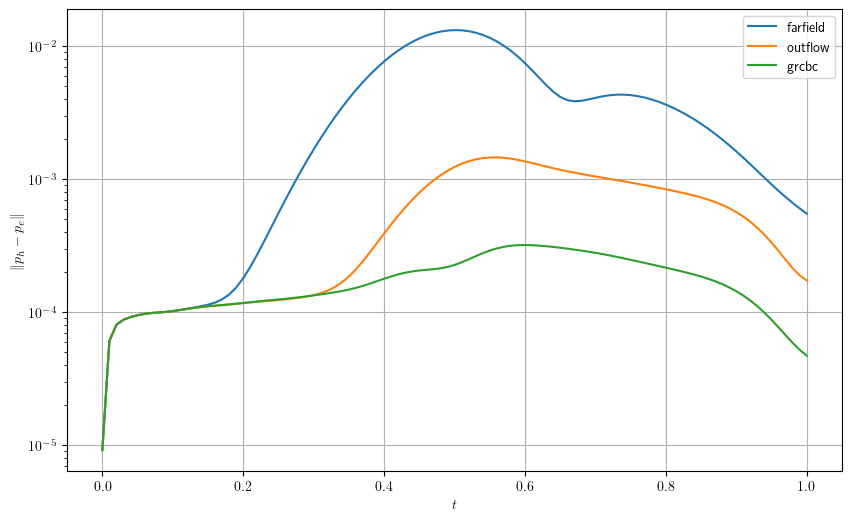

In [18]:
# Postprocessing: Plot sensor data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
for folder in ["farfield", "outflow", "grcbc"]:

    cfg.io.path = folder
    t, data = cfg.io.sensor.load_csv_as_dict("l2")
    ax.semilogy(np.array(t, dtype=float), data[('air', 'pressure', 'L2')], label=folder)

ax.legend();
ax.grid();
ax.set_xlabel(r"$t$");
ax.set_ylabel(r"$\| p_h - p_e \|$");